In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Load Data

In [281]:
# #try two different lambdas
# lam_1, lam_2 = -1e0, -1e-2
# x_1 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 1)
# x_2 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 0)

# # Plot the results
# plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam_1}$')
# plt.plot(np.linspace(0, T, N), x_2[:,0], label = f'$\lambda_1(A) = {lam_2}$')

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('x[0]')
# plt.title('Noisy Linear Filter $\dot{x} = Ax + w(t)$')

# plt.show()

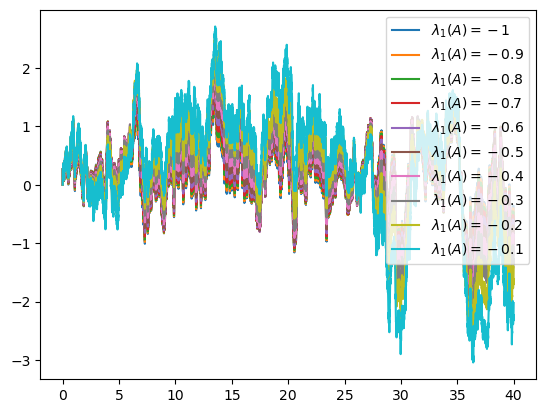

# Grid Search

In [283]:
num_samples = 10
indices = np.random.choice(np.arange(n), num_samples, replace=False)

In [285]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
)
# exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 1 - 1e-4, 1 - 1e-6, 1 - 1e-8, 1- 1e-10, 1- 1e-12, 1 - 1e-14, 1])

In [286]:
def compute_explained_variance(S):
    return np.cumsum(S**2/((S**2).sum()))

prediction_time = 3000
transient = 2000

In [287]:
results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delases = []
        exp_variances = []
#         train_signals = []
        test_signals = []
        for key, signal in trajs.items():
            train_signal = signal[transient:transient + window, indices]
            test_signal = signal[transient + window:transient + window + prediction_time, indices]
            delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda', dtype='torch.DoubleTensor')
       
            exp_variances.append(compute_explained_variance(delase.S.cpu().double().numpy()))
            delases.append(delase)
#             train_signals.append(train_signal)
            test_signals.append(test_signal)
            
        for thresh in exp_variance_vals:
            r = np.max([int(np.argmax(exp_variance > thresh)) for exp_variance in exp_variances])
            if r == 0:
                r = np.min([len(exp_variances) for exp_variance in exp_variances])
            
#             ips = []
            stab_curves = []
            AICs = []
            for i, delase in enumerate(delases):
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)
                
                N = test_signals[i].shape[0]*test_signals[i].shape[1]
                preds = delase.predict_havok_dmd(test_signals[i], use_real_coords=True)
                AIC = float(N*np.log(((preds.cpu() - test_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
#                 N = train_signals[i].shape[0]*train_signals[i].shape[1]
#                 preds = delase.predict_havok_dmd(train_signals[i], use_real_coords=True)
#                 AIC = float(N*np.log(((preds.cpu() - train_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
                AICs.append(AIC)
                stab_curves.append(delase.stability_params.cpu())
#                 ip = compute_integrated_performance(delase, test_signals[i], full_return=True)
                
#                 ips.append(ip)
            
            results.append(dict(
                window=window,
                matrix_size=matrix_size,
                exp_variances=exp_variances,
                exp_variance_thresh=thresh,
                r=r,
#                 ips=ips,
                AICs=AICs,
                stab_curves=stab_curves,
            ))
            
            pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_linear_models_AIC_comparison.pkl'))
            
            iterator.update()
iterator.close()

  0%|          | 0/135 [00:00<?, ?it/s]

In [288]:
results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_linear_models_AIC_comparison.pkl')))

In [289]:
results['AIC_mean'] = results.AICs.apply(lambda x: np.mean(x))

In [290]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [291]:
top_percent = 0.1

In [292]:
AIC_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
stab_curve = {}
# wake_stab = {}
# anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        AIC_mean[i, j] = row.AIC_mean
        stab_curve[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_wake.cpu()
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_anesthesia.cpu()

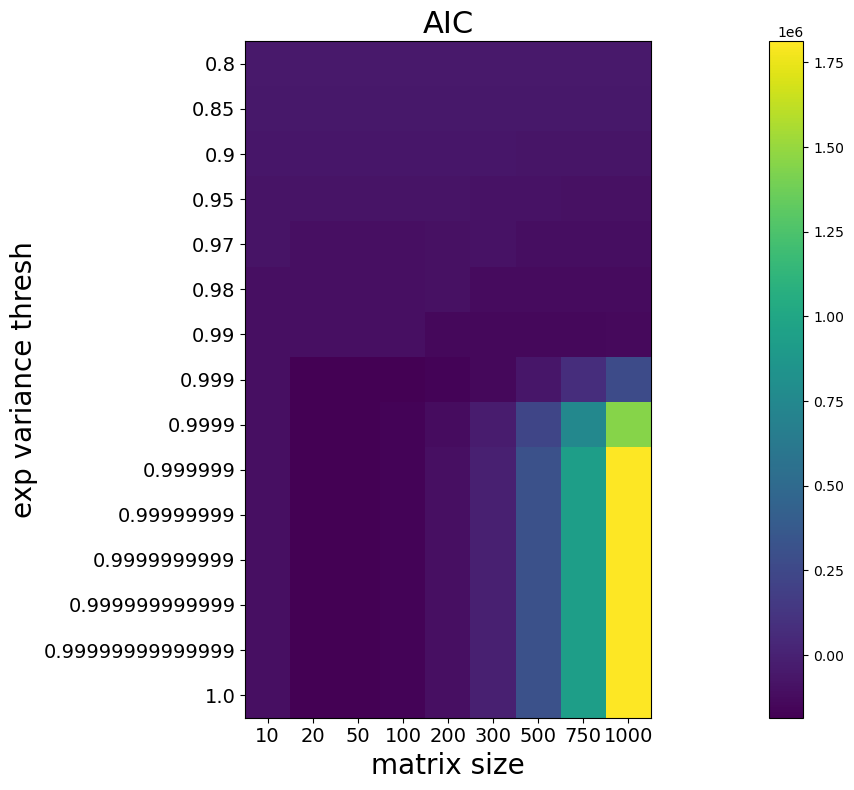

In [293]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC_mean.min(),vmax=AIC_mean.max())

plt.imshow(AIC_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('AIC', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [294]:
# %matplotlib notebook
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = np.arange(AIC_mean.shape[0])
# Y = np.arange(AIC_mean.shape[1])
# X, Y = np.meshgrid(X, Y)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, AIC_mean.T, cmap='coolwarm',
#                        linewidth=0, antialiased=False)
# ax.set_zlim([-50000, 0])

In [295]:
m_index, t_index = np.unravel_index(AIC_mean.argmin(), shape=AIC_mean.shape)
matrix_size_vals[m_index], exp_variance_thresh_vals[t_index]

(20, 0.9999)

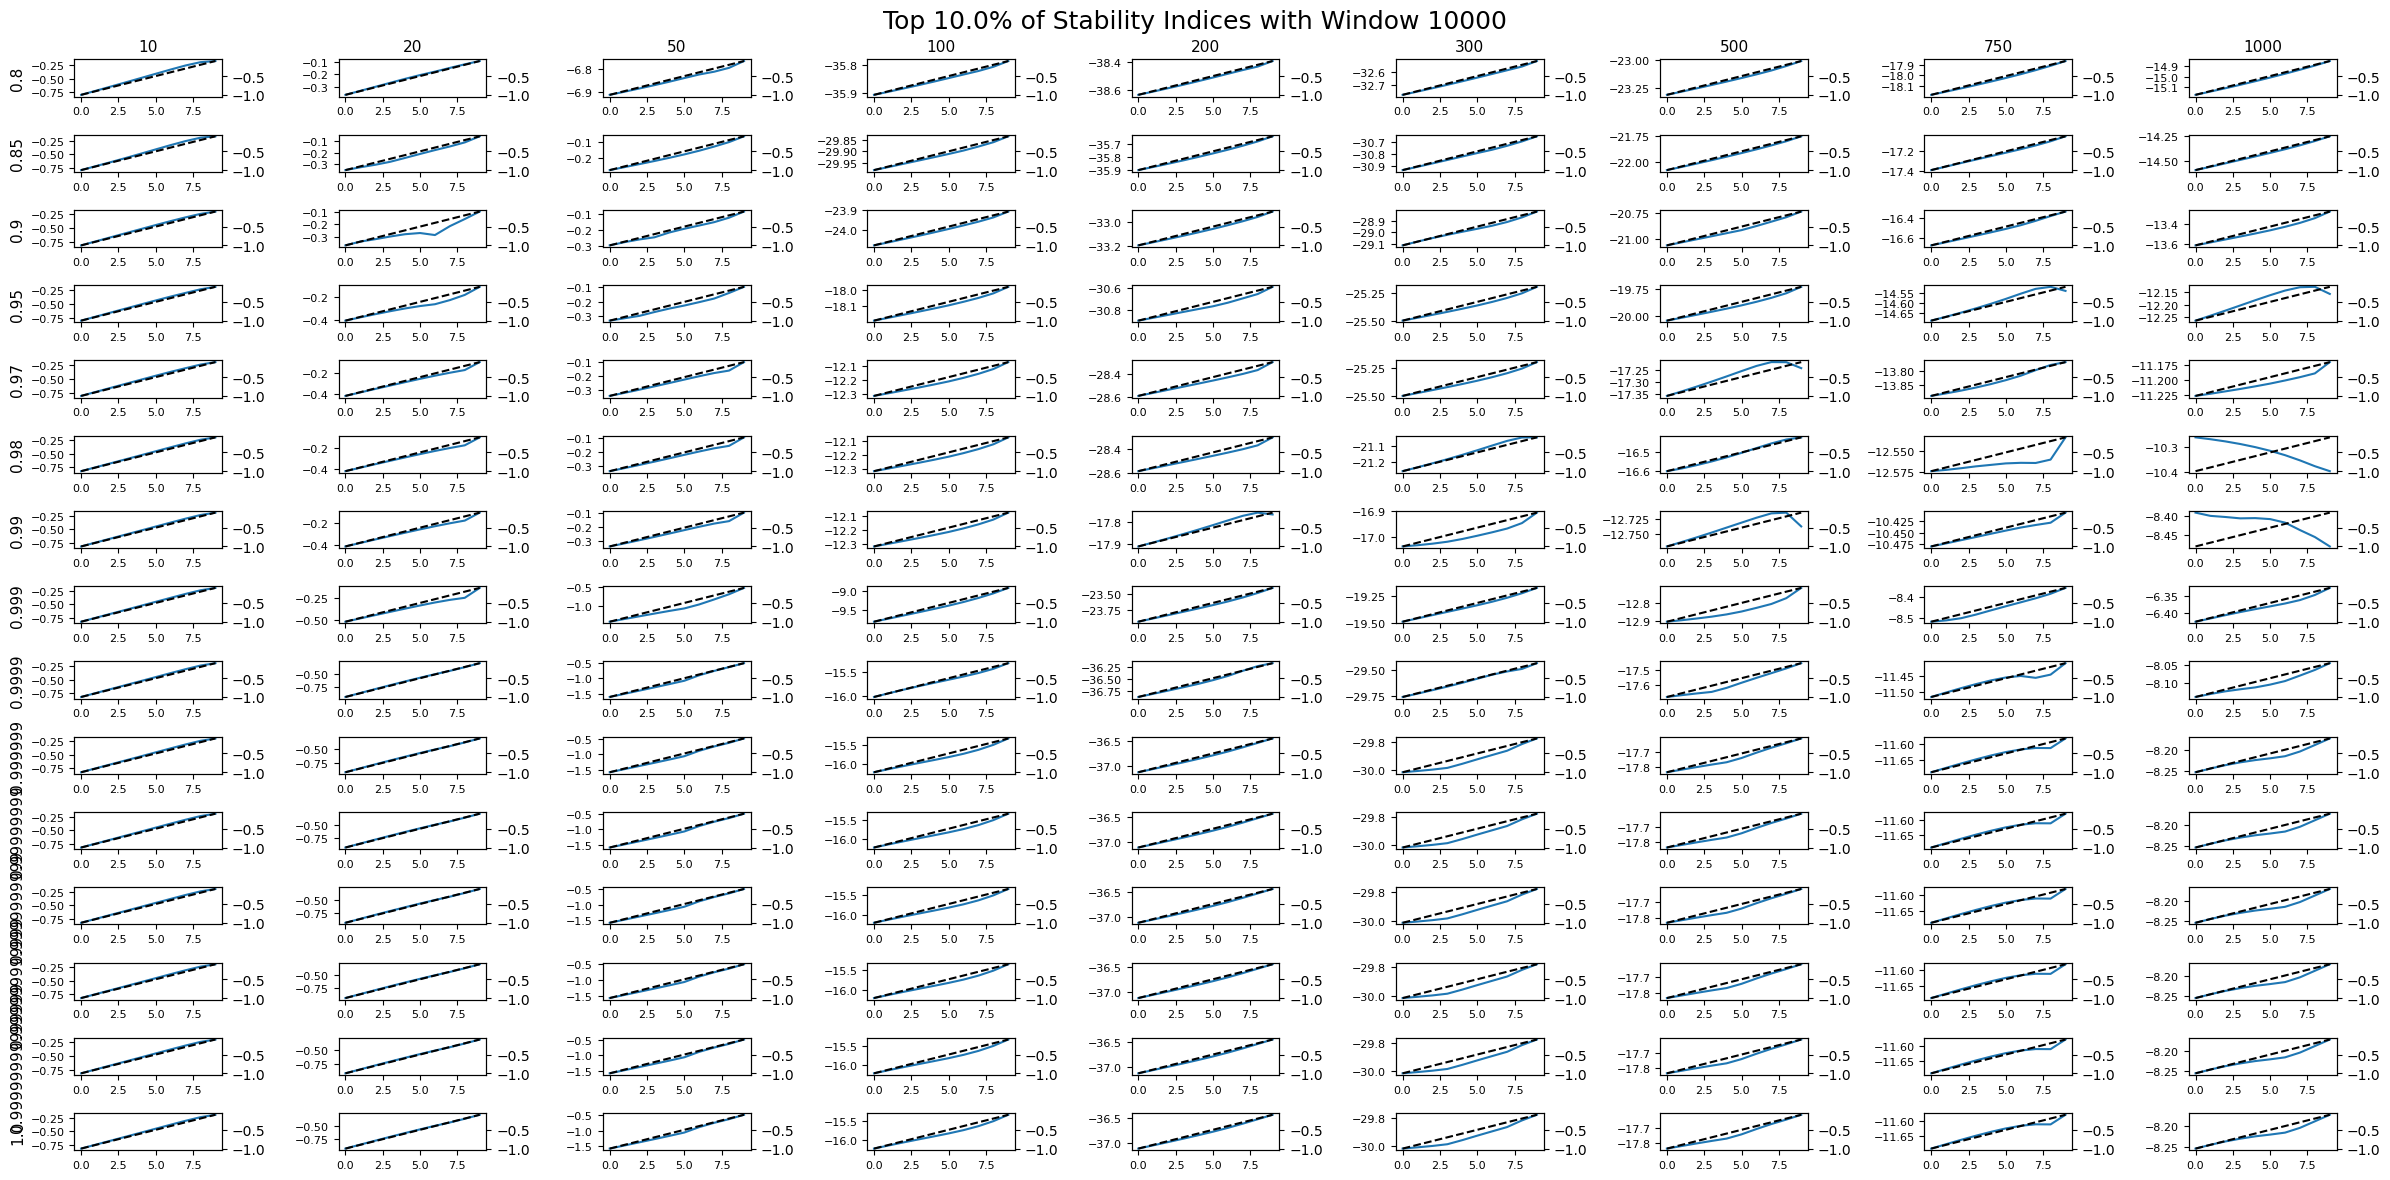

In [296]:
%matplotlib inline
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(24, 12))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(stab_curve[(matrix_size, exp_variance_thresh)])
        ax2 = ax.twinx()
        ax2.plot(lams, linestyle='--', c='k')
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}', fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

# Chaotic Nets

In [448]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [449]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01

In [450]:
noise_sd = 0.1
# noise_sd = 0
normalize = False
# indices = np.random.choice(np. arange(N), size=(50,), replace=False)
indices = pd.read_pickle(os.path.join(chaotic_net_path, "indices.pkl"))
signals = {}
for key in full_signals.keys():
    signals[key] = full_signals[key][0][:, indices] 
    if normalize:
        signals[key] = (signals[key] - signals[key].mean())/signals[key].std()
    signals[key] += np.random.randn(T, len(indices))*noise_sd

In [451]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])

In [452]:
def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

prediction_time = 4000
transient = 2000

In [421]:
results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delases = []
        exp_variances = []
        train_signals = []
        test_signals = []
        for key, signal in signals.items():
            train_signal = signal[transient:transient + window]
            test_signal = signal[transient + window:transient + window + prediction_time]
            delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
       
            exp_variances.append(compute_explained_variance(delase.S.cpu()))
            delases.append(delase)
            train_signals.append(train_signal)
            test_signals.append(test_signal)
            
        for thresh in exp_variance_vals:
            r = np.max([int(np.argmax(exp_variance > thresh)) for exp_variance in exp_variances])
            
            #             ips = []
            stab_curves = []
            AICs = []
            for i, delase in enumerate(delases):
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)

     #                 N = test_signals[i].shape[0]*test_signals[i].shape[1]
#                 preds = delase.predict_havok_dmd(test_signals[i], use_real_coords=True)
#                 AIC = float(N*np.log(((preds.cpu() - test_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
                N = train_signals[i].shape[0]*train_signals[i].shape[1]
                preds = delase.predict_havok_dmd(train_signals[i], use_real_coords=True)
                AIC = float(N*np.log(((preds.cpu() - train_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))

    #                 ip = compute_integrated_performance(delase, test_signals[i], full_return=True)

    #                 ips.append(ip)
                AICs.append(AIC)
                stab_curves.append(delase.stability_params.cpu())

                results.append(dict(
                    window=window,
                    matrix_size=matrix_size,
                    exp_variances=exp_variances,
                    exp_variance_thresh=thresh,
                    r=r,
        #                 ips=ips,
                    AICs=AICs,
                    stab_curves=stab_curves,
                ))
                
            iterator.update()

        pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_chaotic_nets_r_comparison2.pkl'))

            
iterator.close()

  0%|          | 0/99 [00:00<?, ?it/s]

In [453]:
keys= np.array(list(signals.keys()))

In [454]:
results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_chaotic_nets_r_comparison2.pkl')))

In [455]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [456]:
key_inds = np.logical_and(keys >= 1.1, keys <= 1.8)

In [457]:
results['AIC_mean'] = results.AICs.apply(lambda x: np.mean(np.array(x)[key_inds]))

In [472]:
top_percent = 0.15

AIC_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
stab_curve = {}
# wake_stab = {}
# anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        AIC_mean[i, j] = row.AIC_mean
        stab_curve[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_wake.cpu()
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_anesthesia.cpu()

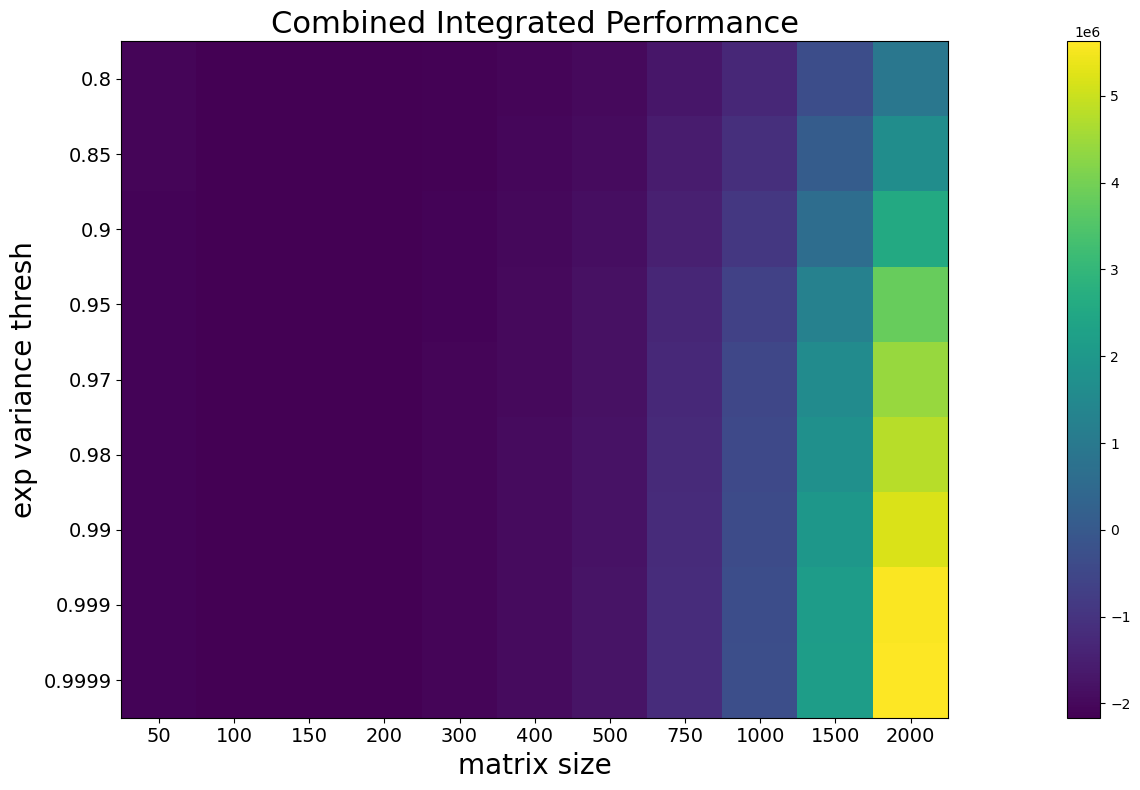

In [467]:
%matplotlib inline
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC_mean.min(),vmax=AIC_mean.max())

plt.imshow(AIC_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [468]:
m_index, t_index = np.unravel_index(AIC_mean.argmin(), shape=AIC_mean.shape)
matrix_size_vals[m_index], exp_variance_thresh_vals[t_index]

(150, 0.8)

In [469]:
AIC_mean[m_index, t_index], AIC_mean[m_index + 1, t_index]

(-2163822.814828165, -2156003.9135432243)

In [470]:
max_lyaps = [lyaps[key][0] for key in keys[key_inds]]

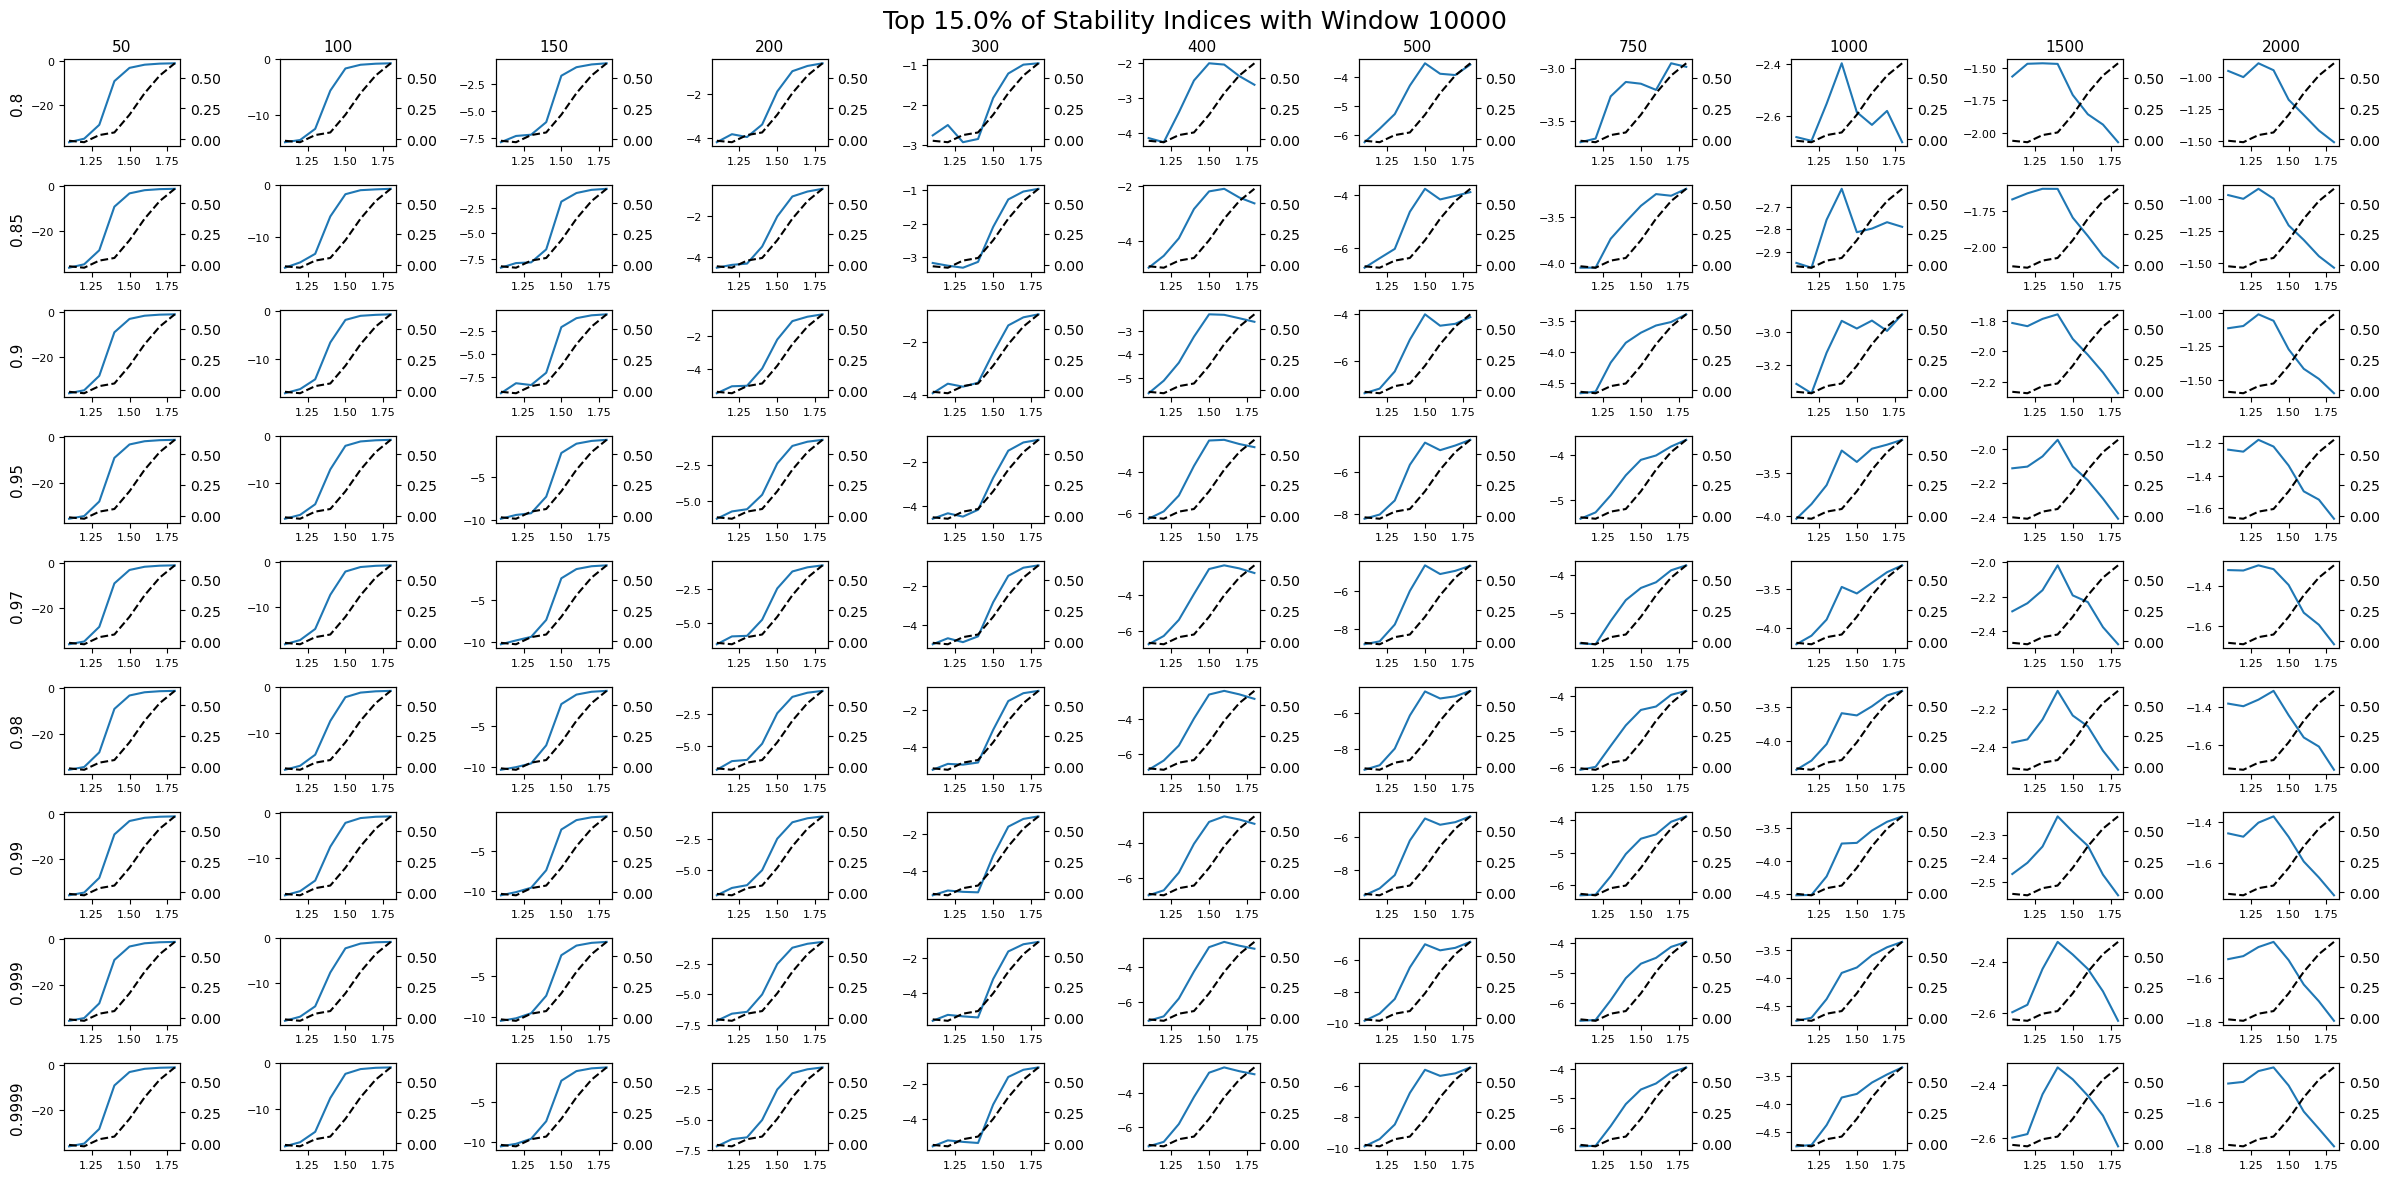

In [473]:
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(24, 12))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(keys[key_inds], stab_curve[(matrix_size, exp_variance_thresh)][key_inds])
        ax2 = ax.twinx()
        ax2.plot(keys[key_inds], max_lyaps, linestyle='--', c='k')
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}', fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

# Neural Data AIC

### Load Some Data

In [3]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [7]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [8]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [201]:
session_info['drugStart']

array([3548.04026667, 5348.04026667])

In [203]:
wake_t = 500
anesthesia_t = 5300
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [204]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 30, directory, unit_indices)
# wake_signal_unnormed = deepcopy(wake_signal)
# wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 30, directory, unit_indices)
# anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
# anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Test AIC

In [205]:
signals = {'wake': wake_signal, 'anesthesia': anesthesia_signal}

In [208]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]),
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 1 - 1e-4, 1 - 1e-6, 1 - 1e-8, 1- 1e-10, 1- 1e-12, 1 - 1e-14, 1])

In [254]:
def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

prediction_time = 15000
transient = 0

In [261]:
results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delases = []
        exp_variances = []
#         train_signals = []
        test_signals = []
        for key, signal in signals.items():
            train_signal = signal[transient:transient + window]
            test_signal = signal[transient + window:transient + window + prediction_time]
            delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda', dtype='torch.DoubleTensor')
       
            exp_variances.append(compute_explained_variance(delase.S.cpu().double()))
            delases.append(delase)
#             train_signals.append(train_signal)
            test_signals.append(test_signal)
            
        for thresh in exp_variance_vals:
            r = np.max([int(np.argmax(exp_variance >= thresh)) for exp_variance in exp_variances])
            
            if r == 0:
                r = np.min([len(exp_variances) for exp_variance in exp_variances])
            
#             ips = []
            stab_curves = []
            AICs = []
            for i, delase in enumerate(delases):
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)
                
                N = test_signals[i].shape[0]*test_signals[i].shape[1]
                preds = delase.predict_havok_dmd(test_signals[i], use_real_coords=True)
                AIC = float(N*np.log(((preds.cpu() - test_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
#                 N = train_signals[i].shape[0]*train_signals[i].shape[1]
#                 preds = delase.predict_havok_dmd(train_signals[i], use_real_coords=True)
#                 AIC = float(N*np.log(((preds.cpu() - train_signals[i])**2).sum()/N) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))

#                 ip = compute_integrated_performance(delase, test_signals[i], full_return=True)

#                 ips.append(ip)
                AICs.append(AIC)
                stab_curves.append(delase.stability_params.cpu())

            results.append(dict(
                window=window,
                matrix_size=matrix_size,
                exp_variances=exp_variances,
                exp_variance_thresh=thresh,
                r=r,
#                 ips=ips,
                AICs=AICs,
                stab_curves=stab_curves,
            ))
                
            iterator.update()

        pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_neural_AIC_comparison_MRJ.pkl'))

            
iterator.close()

  0%|          | 0/210 [00:00<?, ?it/s]

In [262]:
# results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_neural_AIC_comparison.pkl')))
results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_neural_AIC_comparison_MRJ.pkl')))

In [263]:
results['AIC_mean'] = results.AICs.apply(lambda x: np.mean(x))

In [264]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [265]:
top_percent = 0.2

In [266]:
AIC_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
# stab_curve = {}
wake_stab = {}
anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        AIC_mean[i, j] = row.AIC_mean
#         wake_stab[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
        wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[0][:int(top_percent*len(row.stab_curves[0]))]
        anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[1][:int(top_percent*len(row.stab_curves[1]))]

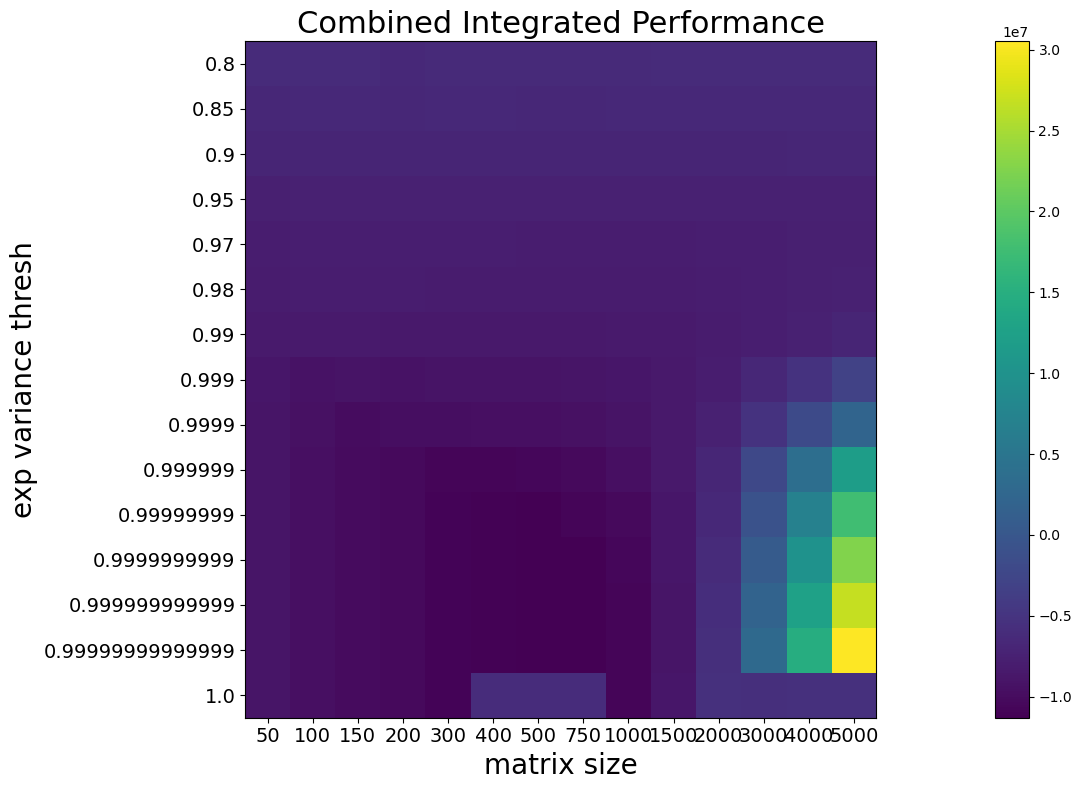

In [267]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC_mean.min(),vmax=AIC_mean.max())

plt.imshow(AIC_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [274]:
m_index, t_index = np.unravel_index(AIC_mean.argmin(), shape=AIC_mean.shape)
matrix_size_vals[m_index], f"1 - {1 - exp_variance_thresh_vals[t_index]:2.0e}"

(750, '1 - 1e-10')

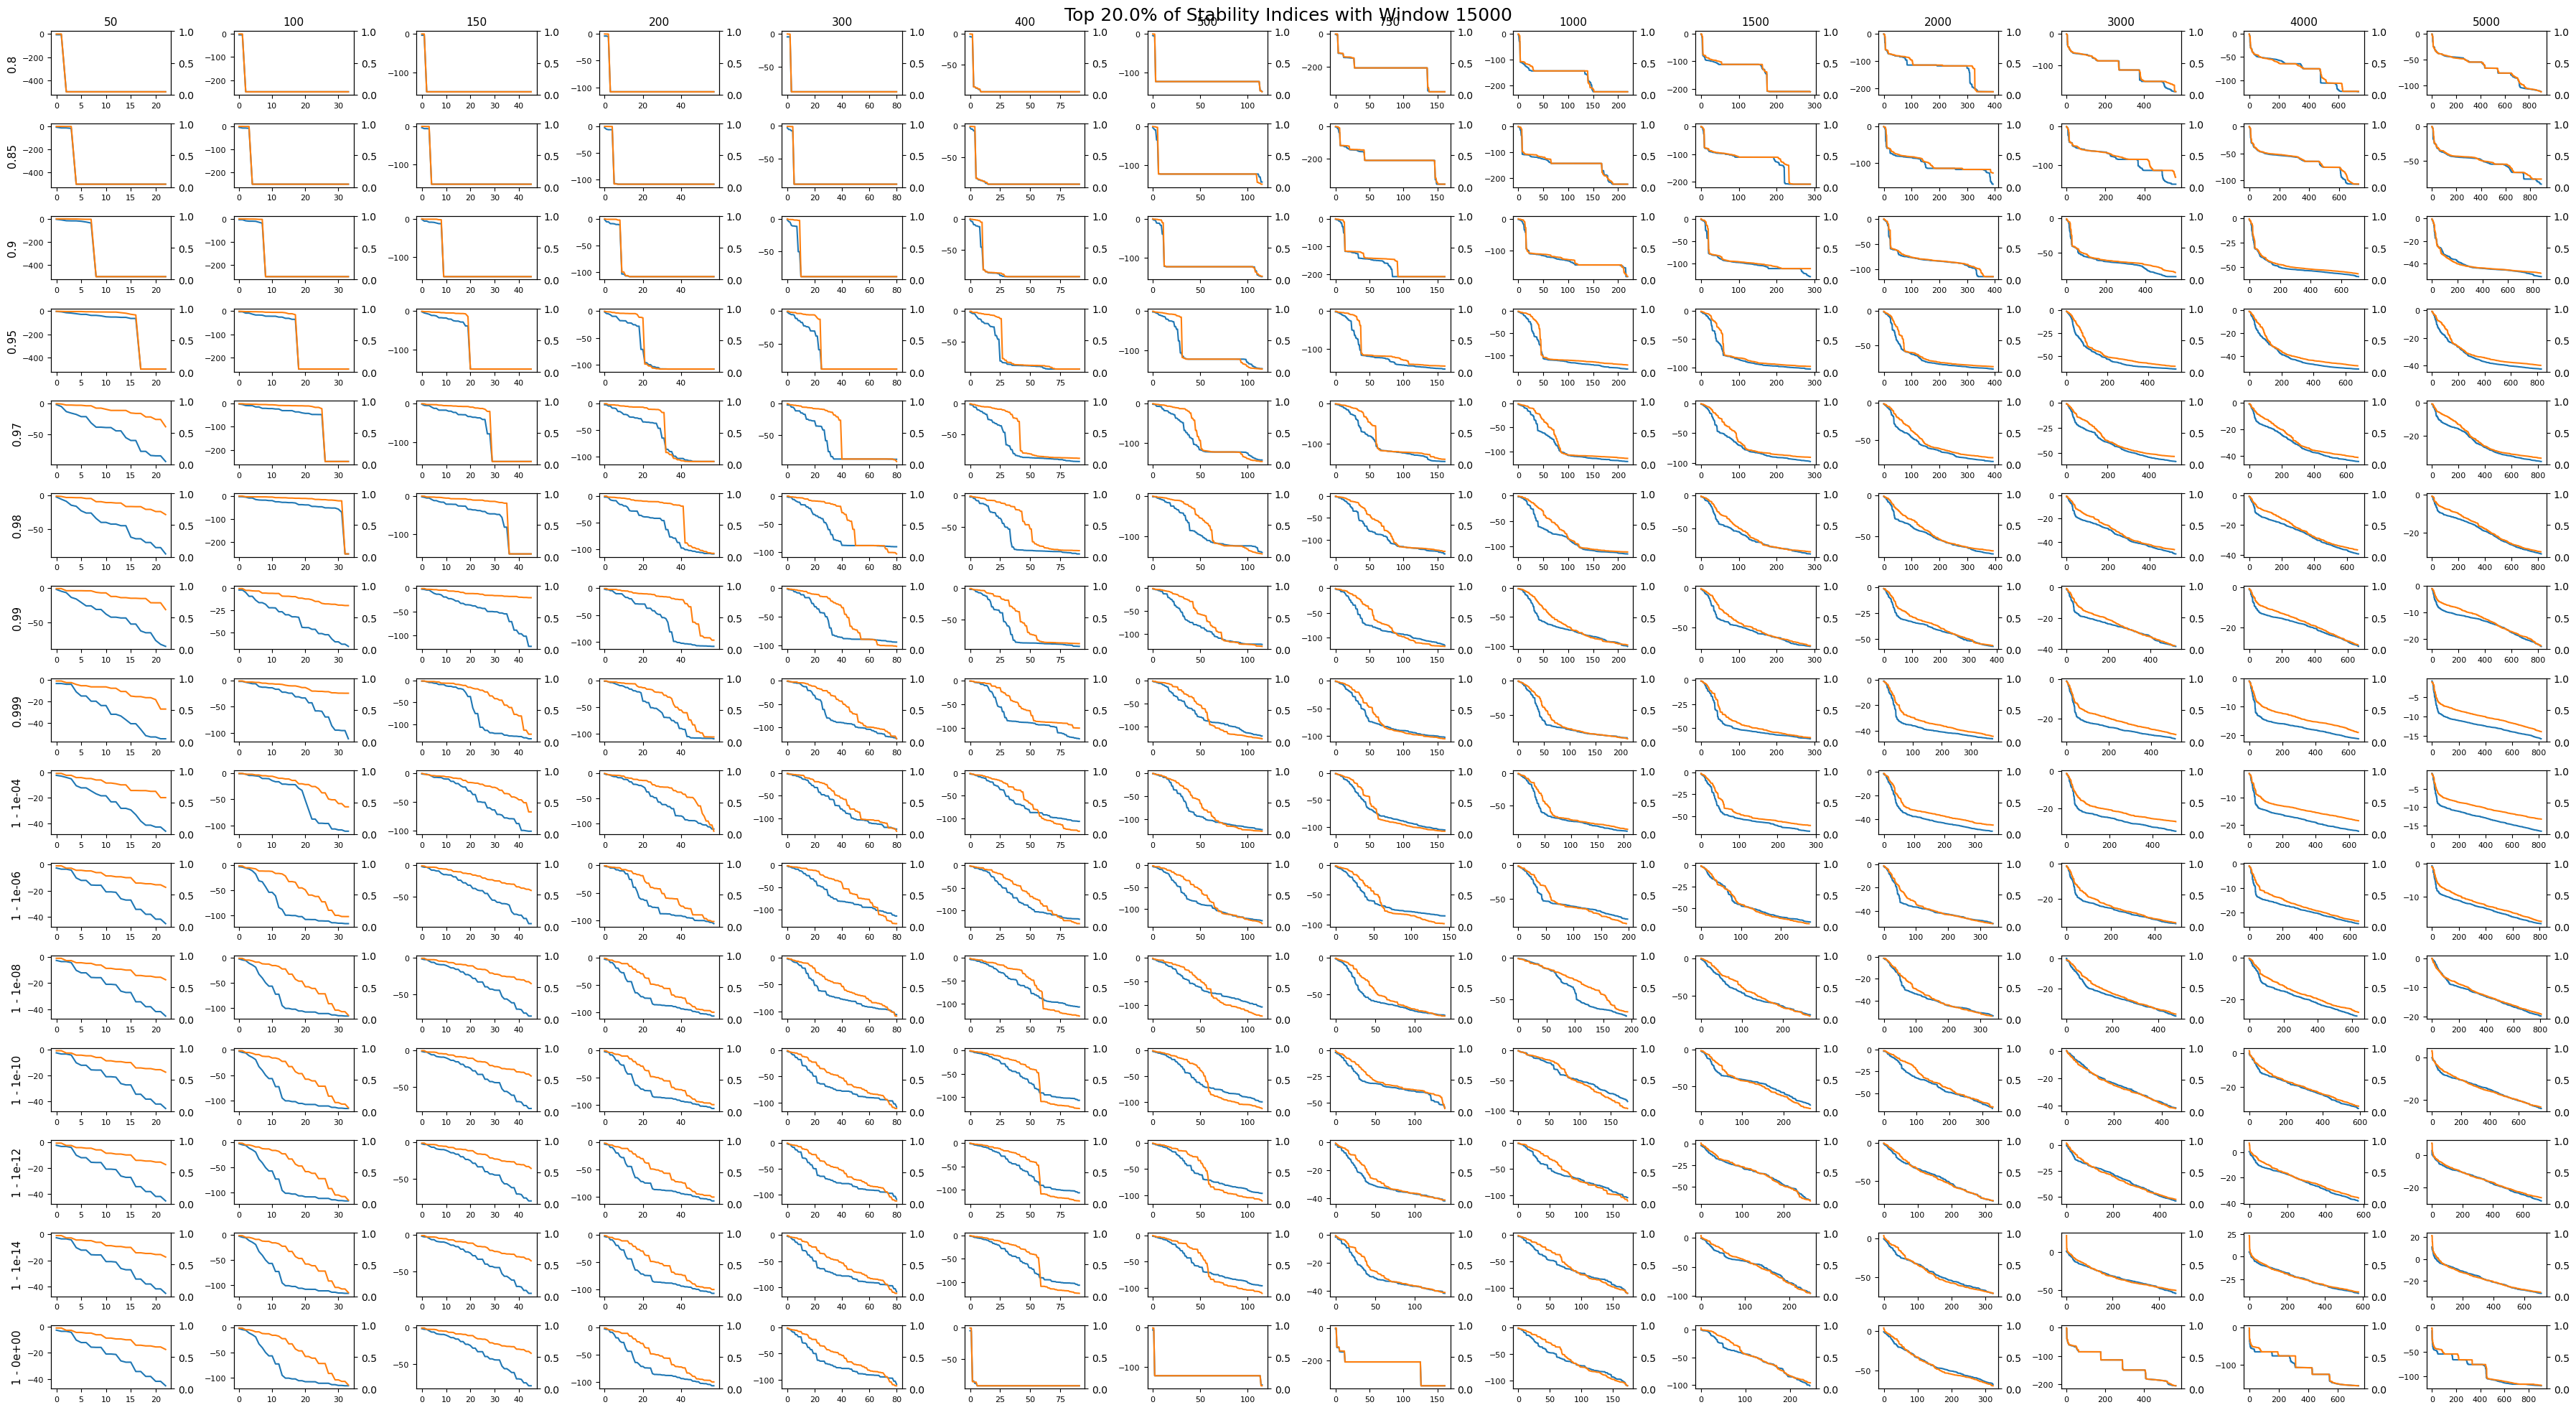

In [277]:
%matplotlib inline
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(36, 20))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(wake_stab[(matrix_size, exp_variance_thresh)])
        ax.plot(anesthesia_stab[(matrix_size, exp_variance_thresh)])
        ax2 = ax.twinx()
#         ax2.plot(lams, linestyle='--', c='k')
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}' if exp_variance_thresh <= 0.999 else f"1 - {1 - exp_variance_thresh:2.0e}", fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

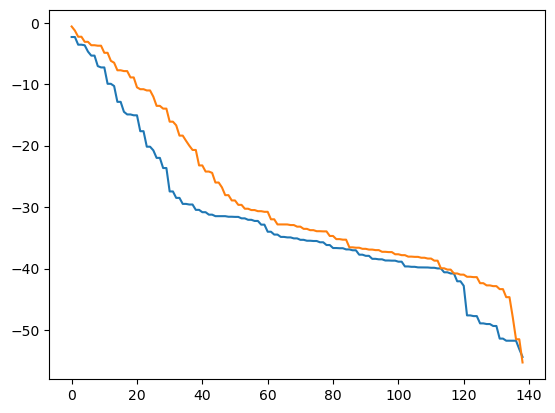

In [278]:
plt.plot(wake_stab[(matrix_size_vals[m_index], exp_variance_thresh_vals[t_index])])
plt.plot(anesthesia_stab[(matrix_size_vals[m_index], exp_variance_thresh_vals[t_index])])
plt.show()

In [250]:
results['ip_mean'] = results.ips.apply(lambda x: np.mean([ip['ip'] for ip in x]))

In [251]:
ip_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
# stab_curve = {}
wake_stab = {}
anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        ip_mean[i, j] = row.ip_mean
#         wake_stab[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[0][:int(top_percent*len(row.stab_curves[0]))]
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[1][:int(top_percent*len(row.stab_curves[1]))]

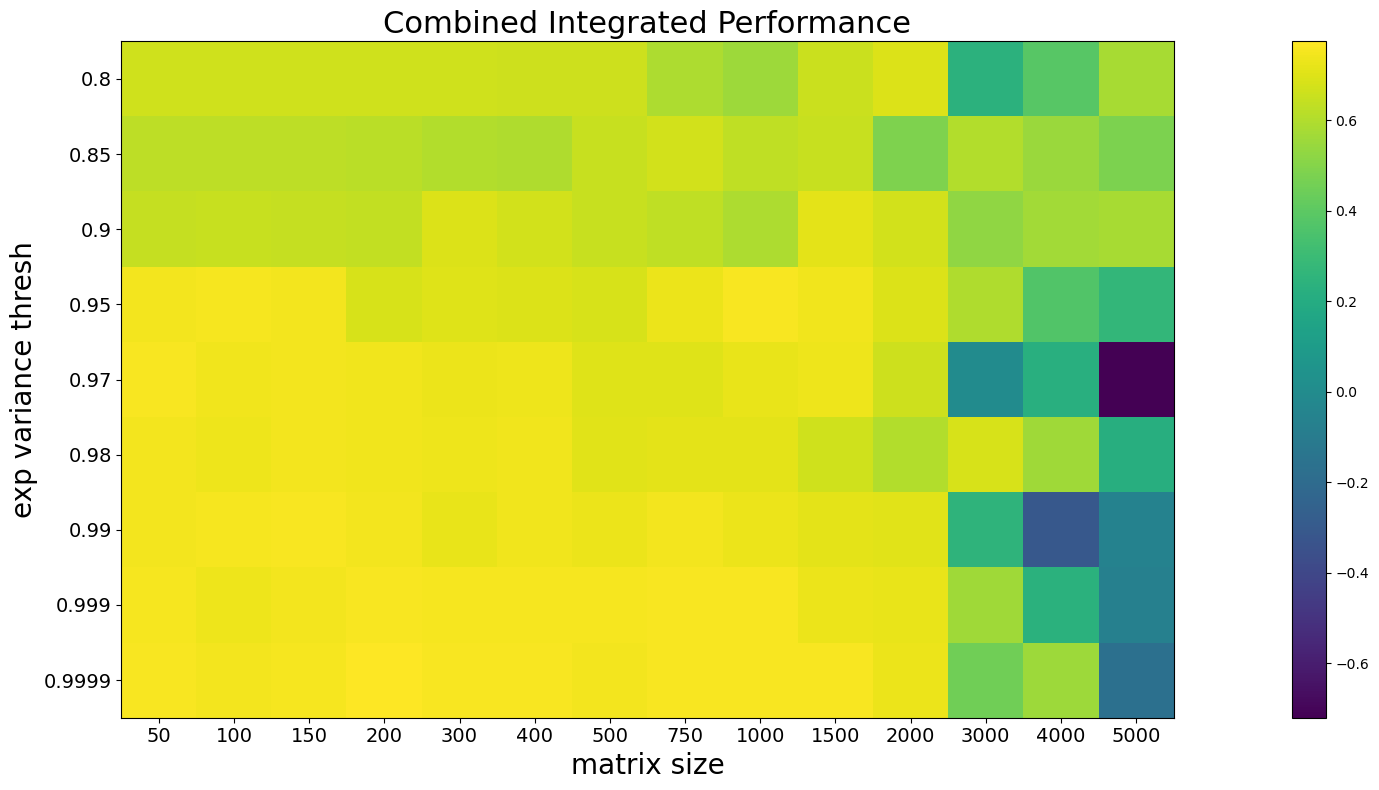

In [252]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=ip_mean.min(),vmax=ip_mean.max())

plt.imshow(ip_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [259]:
AIC_wake = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
AIC_anesthesia = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
# stab_curve = {}
# wake_stab = {}
# anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        AIC_wake[i, j] = row.AICs[0]
        AIC_anesthesia[i, j] = row.AICs[1]
#         wake_stab[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[0][:int(top_percent*len(row.stab_curves[0]))]
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_curves[1][:int(top_percent*len(row.stab_curves[1]))]

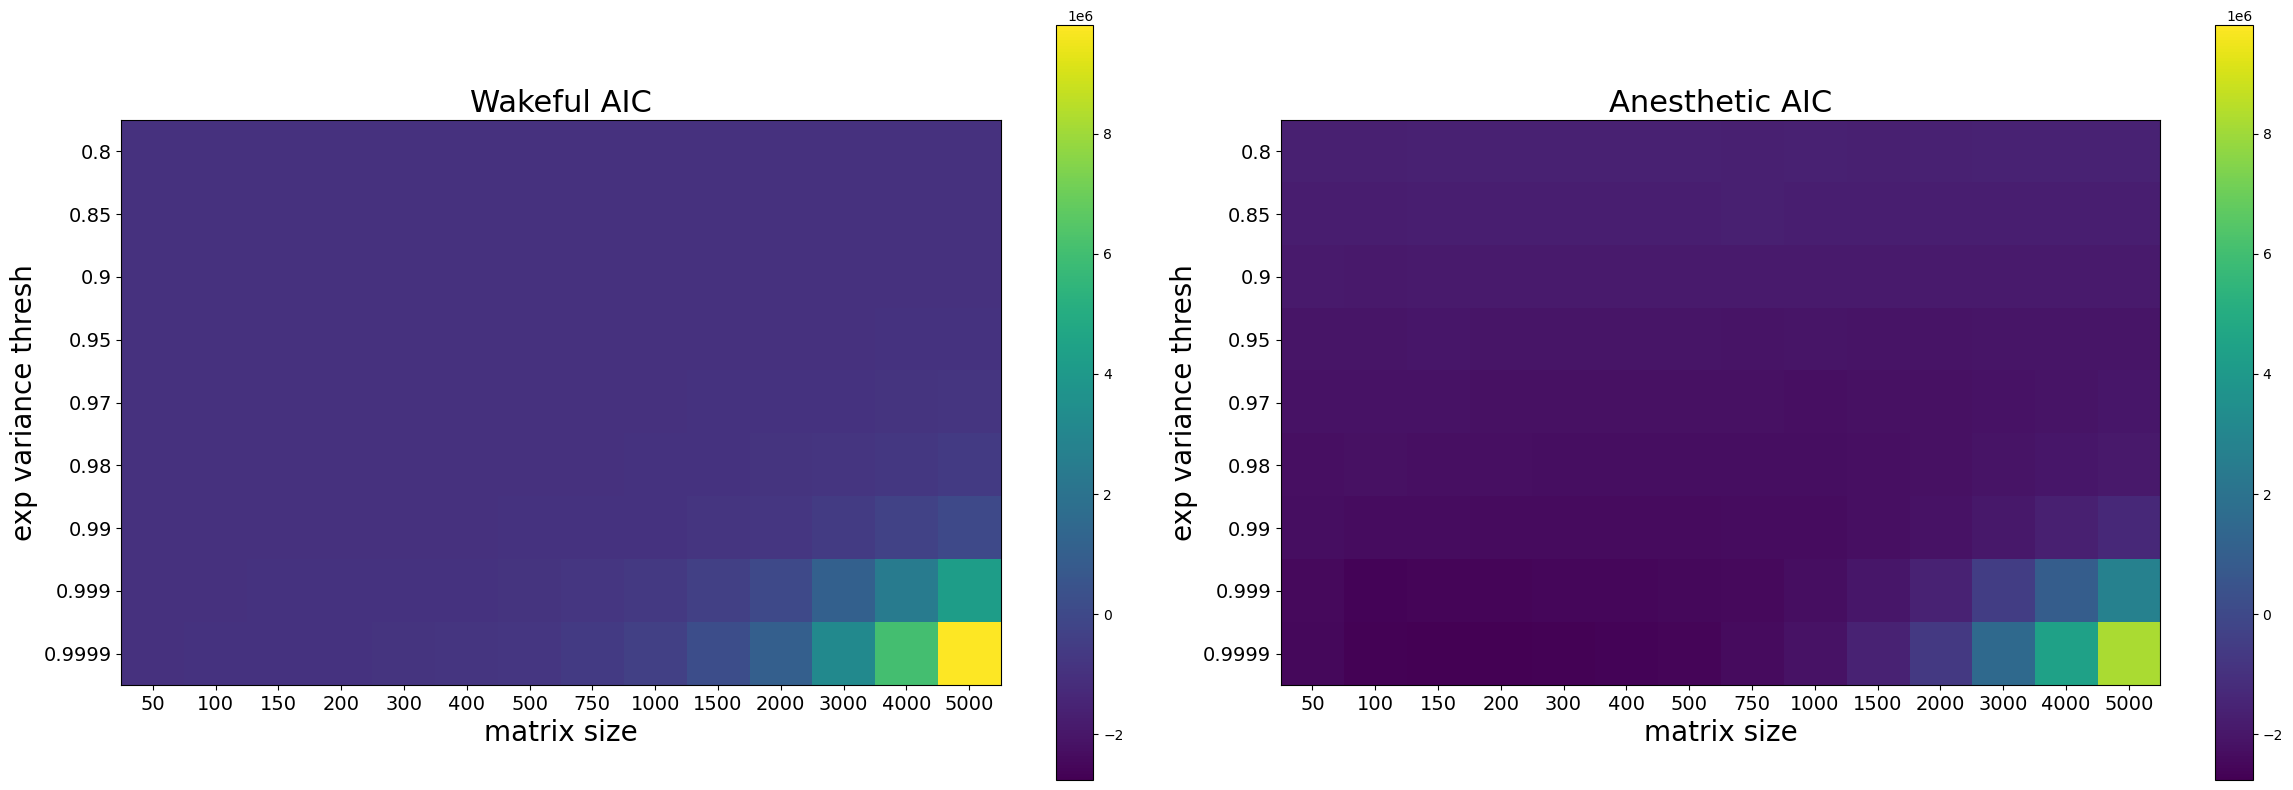

In [262]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=np.min([AIC_wake.min(), AIC_anesthesia.min()]),vmax=np.max([AIC_wake.max(), AIC_anesthesia.max()]))
plt.subplot(1, 2, 1)
plt.imshow(AIC_wake.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Wakeful AIC', fontsize=22)
plt.colorbar(ax=ax)

plt.subplot(1, 2, 2)
plt.imshow(AIC_anesthesia.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Anesthetic AIC', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [274]:
AIC_anesthesia[start_x:end_x]

array([[-1638212.90507786, -1739190.47159501, -1834488.93396681,
        -2042457.08658285, -2153929.67076402, -2229582.53450154,
        -2311733.09837562, -2449540.22455963, -2495989.23827334],
       [-1635287.06818129, -1734827.79604374, -1880650.87107563,
        -2034160.32039077, -2130913.95165426, -2211759.16790605,
        -2335762.08540526, -2631046.03100321, -2696980.61288579],
       [-1631539.7198169 , -1729192.90010387, -1869087.60462539,
        -2023577.31714079, -2151378.13546697, -2256941.06937304,
        -2368303.41100413, -2572404.45994724, -2764868.70644323],
       [-1627085.22514292, -1722515.00855118, -1855878.93386896,
        -2050572.53628525, -2184427.10574412, -2260039.17771306,
        -2383728.95185683, -2592191.48365259, -2719804.60107468],
       [-1616443.33243814, -1724675.11497905, -1843355.14643146,
        -2062953.92927671, -2199287.2297675 , -2287120.59150172,
        -2400881.18832951, -2554079.91331576, -2670931.5289553 ],
       [-1610455.852

SyntaxError: invalid syntax (1910939393.py, line 1)

In [277]:
np.min([AIC_wake[start_x:end_x].min(), AIC_anesthesia[start_x:end_x].min()])

SyntaxError: invalid syntax (515237814.py, line 1)

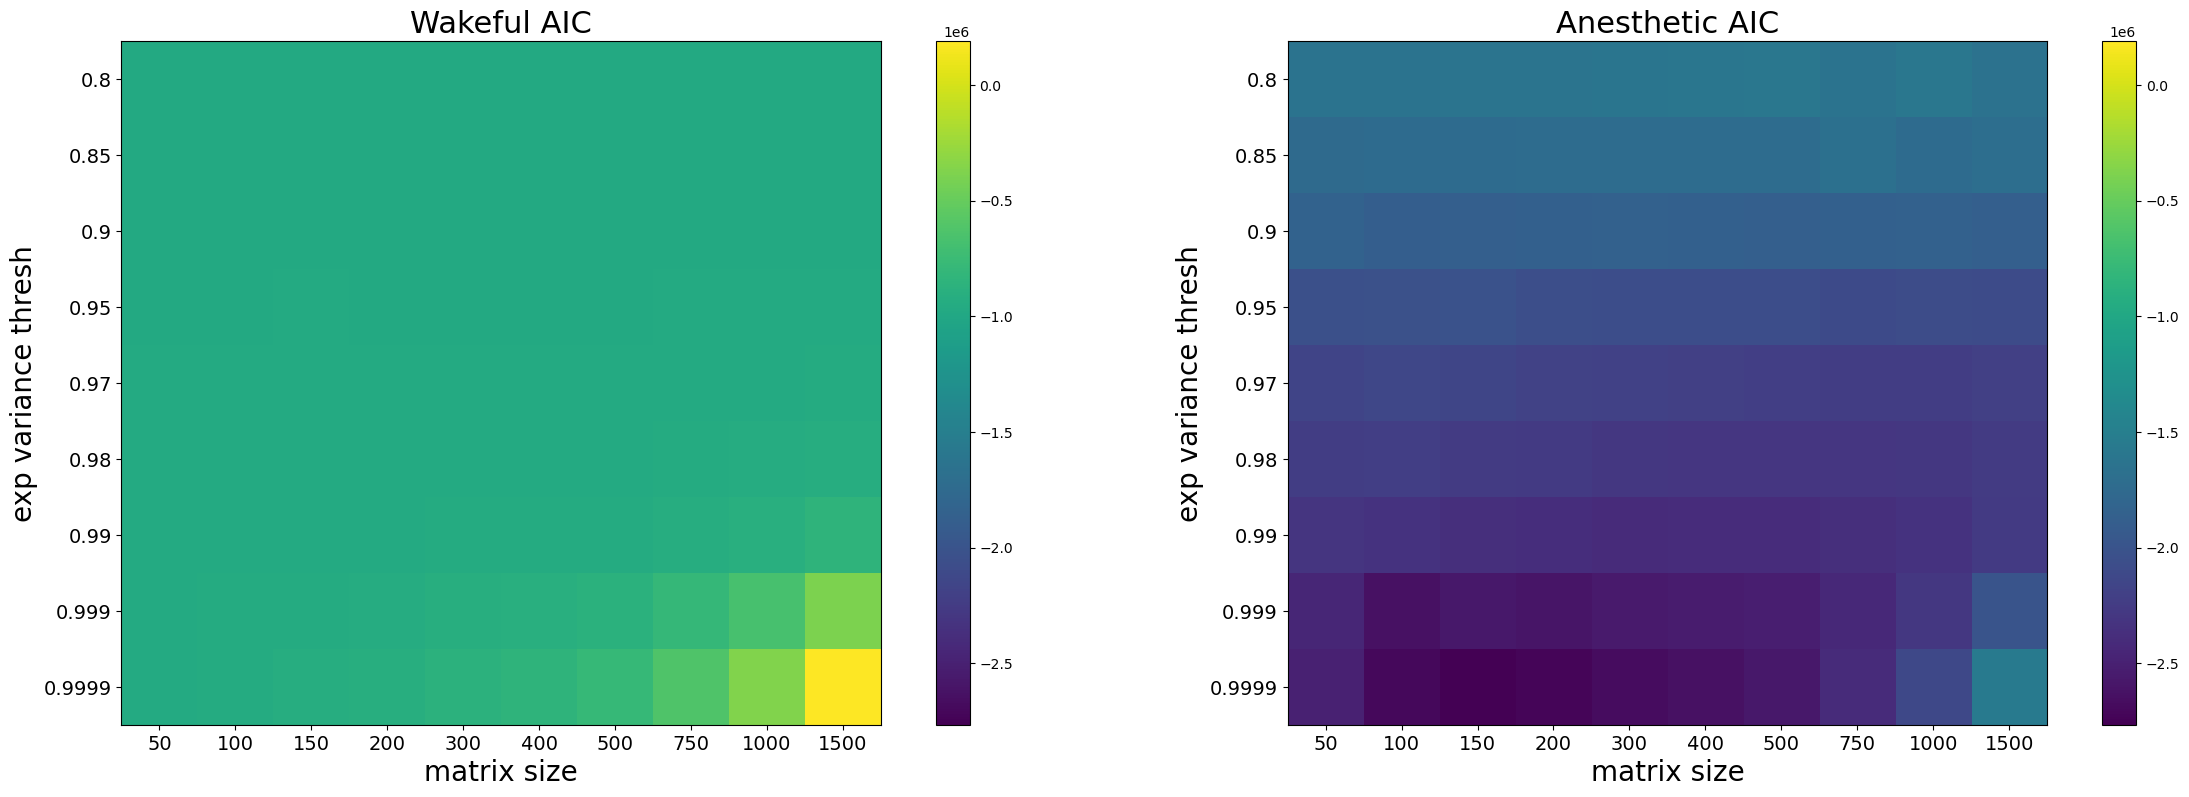

In [278]:
plt.figure(figsize=(24, 8))

start_x = 0
end_x = 10

norm = Normalize(vmin=np.min([AIC_wake[start_x:end_x].min(), AIC_anesthesia[start_x:end_x].min()]),vmax=np.max([AIC_wake[start_x:end_x].max(), AIC_anesthesia[start_x:end_x].max()]))
plt.subplot(1, 2, 1)
plt.imshow(AIC_wake.T[:, start_x:end_x], norm=norm)
plt.xticks(np.arange(len(matrix_size_vals))[start_x:end_x], [f"{matrix_size}" for matrix_size in matrix_size_vals[start_x:end_x]])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Wakeful AIC', fontsize=22)
plt.colorbar(ax=ax)

plt.subplot(1, 2, 2)
plt.imshow(AIC_anesthesia.T[:, start_x:end_x], norm=norm)
plt.xticks(np.arange(len(matrix_size_vals))[start_x:end_x], [f"{matrix_size}" for matrix_size in matrix_size_vals[start_x:end_x]])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Anesthetic AIC', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [263]:
m_index_wake, t_index_wake = np.unravel_index(AIC_wake.argmin(), shape=AIC_wake.shape)
matrix_size_vals[m_index_wake], exp_variance_thresh_vals[t_index_wake]

(5000, 0.8)

In [264]:
m_index_anesthesia, t_index_anesthesia = np.unravel_index(AIC_anesthesia.argmin(), shape=AIC_anesthesia.shape)
matrix_size_vals[m_index_anesthesia], exp_variance_thresh_vals[t_index_anesthesia]

(150, 0.9999)

In [268]:
np.abs(AIC_wake[m_index_wake, t_index_wake] - AIC_wake[m_index, t_index])/AIC_wake[m_index_wake, t_index_wake]

-0.050886523429263655